# Reading labels

## `ClassConfig`

Before we can work with labels, we first want to define what our target classes are -- their names, their IDs, and possibly, their colors (to use for visualization).

In [1]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(names=['background', 'foreground'])
class_config

ClassConfig(names=['background', 'foreground'], colors=[(244, 153, 180), (1, 235, 86)], null_class=None)

(Note how a unique color was generated for each class.)

We can query the ID of a class like so:

In [2]:
print('background', class_config.get_class_id('background'))
print('foreground', class_config.get_class_id('foreground'))

background 0
foreground 1


In the example above, `ClassConfig` automatically generated a color for each class. We could have instead manually specified them. The colors can be any color-string recognized by `PIL`.

In [3]:
class_config = ClassConfig(
    names=['background', 'foreground'],
    colors=['lightgray', 'darkred'])
class_config

ClassConfig(names=['background', 'foreground'], colors=['lightgray', 'darkred'], null_class=None)

---

### The "null" class

Geospatial rasters can have `NODATA` pixels. This is relevant for semantic segmentation where you need to assign a label to every pixel.

You may either want to assign them a class of their own or consider them a part of a catch-all "background" class.

`ClassConfig`'s name for this class is the "null class". Below are some ways that you can define it.

1. Designate one class as the "null" class.

In [4]:
class_config = ClassConfig(names=['background', 'foreground'], null_class='background')
class_config

ClassConfig(names=['background', 'foreground'], colors=[(235, 58, 174), (150, 29, 74)], null_class='background')

2. Specify a class called "null".

In [5]:
class_config = ClassConfig(names=['null', 'foreground'])
class_config

ClassConfig(names=['null', 'foreground'], colors=[(1, 53, 240), (81, 165, 180)], null_class='null')

3. Call `.ensure_null_class()` to automatically add an additional "null" class.

In [6]:
class_config = ClassConfig(names=['background', 'foreground'])
class_config.ensure_null_class()
class_config

ClassConfig(names=['background', 'foreground', 'null'], colors=[(58, 135, 29), (211, 60, 215), 'black'], null_class='null')

---

### Normalized colors

The example below shows how we can easily create a color-map from our class colors.

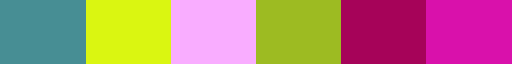

In [7]:
from matplotlib.colors import ListedColormap

class_config = ClassConfig(names=['a', 'b', 'c', 'd', 'e', 'f'])
cmap = ListedColormap(class_config.color_triples)
cmap

<hr style="border:2px solid gray">

## `LabelSource`

---

### Semantic Segmentation - `SemanticSegmentationLabelSource`

The main added service it provides is ensuring that if a chip overflows the extent, the overflowing pixels are assigned the ID of the "null class".

---

The example below shows how to create a `SemanticSegmentationLabelSource` from rasterized vector labels.

In [8]:
img_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/RGB-PanSharpen_AOI_2_Vegas_img205.tif'
label_uri = 's3://azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson'

Define `ClassConfig`:

In [9]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

In [10]:
from rastervision.core.data import (
    ClassInferenceTransformer, GeoJSONVectorSource,
    RasterioSource, RasterizedSource)

img_raster_source = RasterioSource(img_uri, allow_streaming=True)

vector_source = GeoJSONVectorSource(
    label_uri,
    img_raster_source.crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('building'))])

label_raster_source = RasterizedSource(
    vector_source,
    background_class_id=class_config.null_class_id,
    extent=img_raster_source.extent)

2022-09-13 12:08:55:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/azavea-research-public-data/raster-vision/examples/spacenet/buildings_AOI_2_Vegas_img205.geojson.


Create a `SemanticSegmentationLabelSource` from the `RasterizedSource`.

In [11]:
from rastervision.core.data import SemanticSegmentationLabelSource

label_source = SemanticSegmentationLabelSource(
    label_raster_source, class_config=class_config)

We can sample label-chips like so:

In [12]:
label_chip = label_source[:400, :400]

## equivalent to:
#
# from rastervision.core.box import Box
# label_chip = label_source.get_label_arr(Box(0, 0, 400, 400))

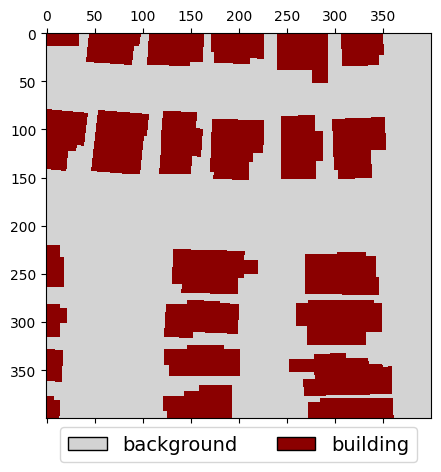

In [13]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import patches

fig, ax = plt.subplots(figsize=(5, 5))
cmap = ListedColormap(class_config.color_triples)
ax.matshow(label_chip, cmap=cmap)

legend_items = [
    patches.Patch(facecolor=cmap(i), edgecolor='black', label=cname)
    for i, cname in enumerate(class_config.names)]
ax.legend(
    handles=legend_items, 
    ncol=len(class_config), 
    loc='upper center', 
    fontsize=14,
    bbox_to_anchor=(0.5, 0))
plt.show()

<hr style="border:2px solid gray">

### Object Detection - `ObjectDetectionLabelSource`

The bounding-box-to-window matching behavior can be further controlled by specifying an `ioa_thresh` (intersection-over-area threshold for considering a bounding box a part of a window) and a `clip` flag which ensures that bounding boxes do not overflow the window.

---

Download (~500 KB) and unzip data:

In [14]:
!wget "https://github.com/azavea/raster-vision-data/releases/download/v0.0.1/cowc-potsdam-labels.zip"
!apt-get install unzip
!unzip "cowc-potsdam-labels.zip" -d "cowc-potsdam-labels/"

In [15]:
img_uri = 's3://azavea-research-public-data/raster-vision/examples/tutorials-data/top_potsdam_2_10_RGBIR.tif'
label_uri = 'cowc-potsdam-labels/labels/train/top_potsdam_2_10_RGBIR.json'

Create
- a `RasterSource` to get the image extent and a `CRSTRansformer`
- a `VectorSource` to read the vector labels
- an `ObjectDetectionLabelSource` to convert data from `VectorSource` into object detection labels

In [16]:
from rastervision.core.data import (
    ClassConfig, ClassInferenceTransformer, GeoJSONVectorSource,
    ObjectDetectionLabelSource, RasterioSource)

class_config = ClassConfig(names=['car'], colors=['red'])

raster_source = RasterioSource(img_uri, allow_streaming=True)

vector_source = GeoJSONVectorSource(
    label_uri,
    crs_transformer=raster_source.crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('car'))])

label_source = ObjectDetectionLabelSource(
    vector_source, extent=raster_source.extent, ioa_thresh=0.2, clip=False)

We can sample label data like shown below. Here, we are querying a 1000x1000 chip downscaled by a factor of 2 from the raster source. Using the same index for the `ObjectDetectionLabelSource` gets us all the bounding boxes that fall within the 1000x1000 window and are automatically downscaled by a factor of 2 so that they still align correctly with the image chip.

In [17]:
chip = raster_source[:1000:2, :1000:2]
bboxes, _, _ = label_source[:1000:2, :1000:2]

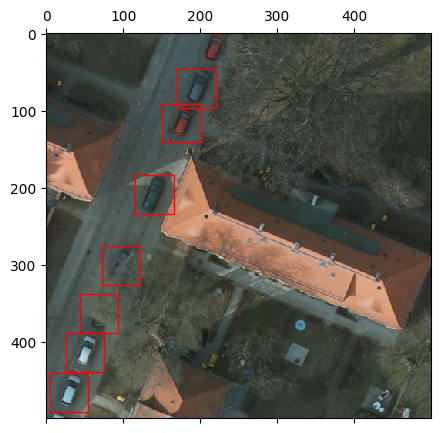

In [18]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import numpy as np
from shapely.geometry import Polygon

fig, ax = plt.subplots(figsize=(5, 5))

ax.matshow(chip[..., :3])

bbox_color = class_config.color_triples[class_config.get_class_id('car')]
bbox_polygons = [Polygon.from_bounds(*bounds) for bounds in bboxes[:, [1, 0, 3, 2]]]
for p in bbox_polygons:
    xy = np.array(p.exterior)
    patch = patches.Polygon(xy, fill=None, color=bbox_color)
    ax.add_patch(patch)
ax.autoscale()

plt.show()

<hr style="border:2px solid gray">

### Chip Classification - `ChipClassificationLabelSource`

1. The trivial case: given a rectangular polygons (representing chips) with associated class IDs, allow querying the class ID for those chips.
2. The more interesting case: given polygons representing the members of the target class(es), infer the class ID for a window based on how much it overlaps with any label-polygon.

The example below showcases the latter.

---

Data source: [SpaceNet 1](https://spacenet.ai/spacenet-buildings-dataset-v1/)

In [20]:
img_uri = 's3://spacenet-dataset/AOIs/AOI_1_Rio/srcData/mosaic_3band/013022232020.tif'
label_uri = 's3://spacenet-dataset/AOIs/AOI_1_Rio/srcData/buildingLabels/Rio_Buildings_Public_AOI_v2.geojson'

Create
- a `RasterSource` to get the image extent and a `CRSTRansformer`
- a `VectorSource` to read the vector labels

In [20]:
from rastervision.core.data import (
    ClassConfig, ClassInferenceTransformer,
    GeoJSONVectorSource, RasterioSource)

class_config = ClassConfig(
    names=['background', 'building'], null_class='background')

raster_source = RasterioSource(img_uri, allow_streaming=True)

vector_source = GeoJSONVectorSource(
    label_uri,
    crs_transformer=raster_source.crs_transformer,
    ignore_crs_field=True,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('building'))])

In [21]:
from rastervision.core.data import (
    ChipClassificationLabelSource, ChipClassificationLabelSourceConfig)

cfg = ChipClassificationLabelSourceConfig(
    ioa_thresh=0.5,
    use_intersection_over_cell=False,
    pick_min_class_id=False,
    background_class_id=class_config.null_class_id,
    infer_cells=True)

label_source = ChipClassificationLabelSource(
    cfg, vector_source, extent=raster_source.extent, lazy=True)

2022-09-13 12:09:08:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/AOIs/AOI_1_Rio/srcData/buildingLabels/Rio_Buildings_Public_AOI_v2.geojson.


Transforming to pixel coords:   4%|4         | 9364/220049 [00:05<01:52, 1872.72it/s]

Splitting multi-part geoms:   8%|8         | 18662/220049 [00:05<00:53, 3732.25it/s]

Simplifying polygons:   8%|7         | 16784/220070 [00:05<01:00, 3356.64it/s]

Splitting multi-part geoms:  18%|#8        | 40611/220057 [00:05<00:22, 8122.11it/s]

---

We can query `ChipClassificationLabelSourceConfig` in the usual way. For a given index/window, `ChipClassificationLabelSourceConfig` retuns a single `int` representing the class ID of the inferred class of that chip.

Querying a 100x100 chip from the corner of the raster, we see that there are no buildings, and indeed the label returned corresponds to the `"background"` class.

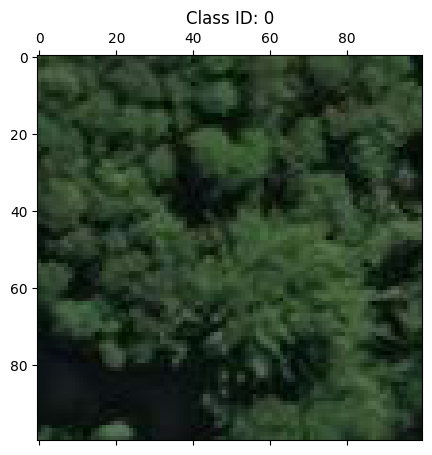

In [22]:
from matplotlib import pyplot as plt

chip = raster_source[:100, :100]
label = label_source[:100, :100]

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip)
ax.set_title(f'Class ID: {label}')
plt.show()

Querying a different chip, we see that it does in fact contain buildings, and the label source agrees -- returning the label corresponding to the `"building"` class.

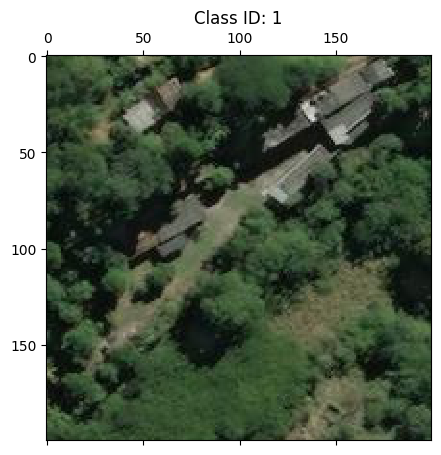

In [23]:
from matplotlib import pyplot as plt

chip = raster_source[:200, 200:400]
label = label_source[:200, 200:400]

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip)
ax.set_title(f'Class ID: {label}')
plt.show()

To get a better sense of `ChipClassificationLabelSource`'s working we will now query the class for many 100x100 chips within a 1500x1500 chunk of the full raster.

In [24]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import numpy as np
from shapely.geometry import Polygon
from rastervision.core.box import Box

chip = raster_source[500:2000, 500:2000]

extent = Box(500, 500, 2000, 2000)
windows = extent.get_windows(100, stride=100)
label_source.populate_labels(cells=windows)

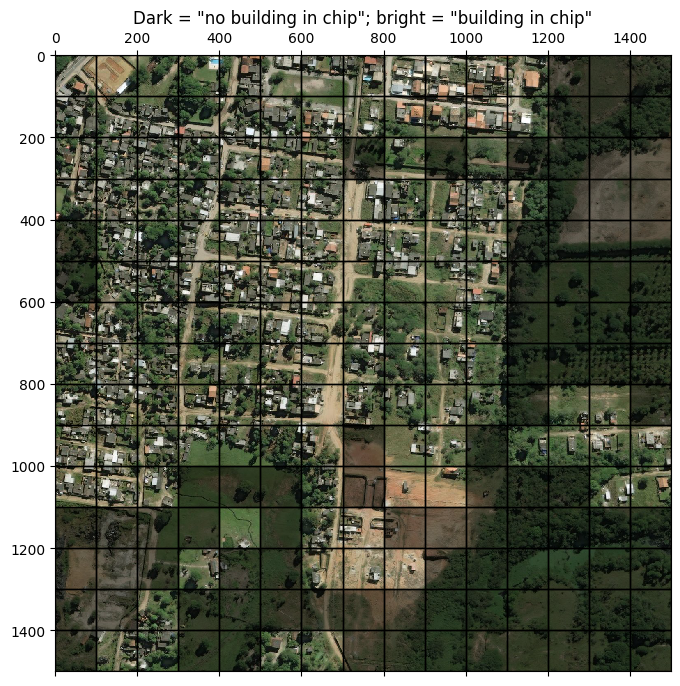

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(chip[..., :3])

for w in windows:
    p = w.translate(-500, -500).to_shapely()
    xy = np.array(p.exterior)
    label = label_source[w] # equivalent to label_source[w.ymin:w.ymax, w.xmin:w.xmax]
    if label == 0:
        patch = patches.Polygon(xy, fc='k', alpha=0.45)
        ax.add_patch(patch)
        patch = patches.Polygon(xy, fill=None, ec='k', alpha=1, lw=1)
    else:
        patch = patches.Polygon(xy, fill=None, ec='k', alpha=1, lw=1)
    ax.add_patch(patch)
ax.set_title('Dark = "no building in chip"; bright = "building in chip"')
plt.show()

<hr style="border:2px solid gray">

## `Labels`

```python
labels = label_source.get_labels(window)
```

Crucially, the predictions produced by a model can also be converted to `Labels` instance, allowing them to be compared agains the `Labels` from the `LabelSource` (i.e, the ground truth) to get performance metrics. This is essentially what `Evaluator` does.